In [1]:
from datetime import datetime
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2015-01-01', '%Y-%m-%d')
end_date = datetime.now()
period = 86400

def get_crypto_data(poloniex_pair):
    poloniex_pair = "BTC_{}".format(poloniex_pair)
    json_url = base_polo_url.format(
        poloniex_pair,
        start_date.timestamp(),
        end_date.timestamp(),
        period
    )
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

def get_json_data(json_url, cache_path):
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
        return df
    
def create_dataset(dataset, lookback=1):
    dataX, dataY = [], []
    for i in range(0, len(dataset) - lookback):
        dataY.append(dataset[i+lookback, 0])
        dataX.append(dataset[i])
    return np.array(dataX), np.array(dataY)

def train_test_split(data, test_size=0.2):
    train_set_size = int(len(data) * (1-test_size))
    train_set = data[:train_set_size]
    test_set = data[-(len(data)-train_set_size):]
    return train_set, test_set

ticker = "OMG"
ds = get_crypto_data(ticker)
ds = ds['close'].dropna(how='all')
ds = ds.values.reshape(len(ds), 1)

scaler = MinMaxScaler(feature_range=(0,1))
ds = scaler.fit_transform(ds)

train, test = train_test_split(ds)

look_back=1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

model = Sequential()
model.add(LSTM(8, input_shape=(1, look_back), dropout=0.2))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=23, batch_size=1, verbose=2)

model_json = model.to_json()
with open("model_{}.json".format(ticker), "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_{}.h5".format(ticker))

Cached https://poloniex.com/public?command=returnChartData&currencyPair=BTC_OMG&start=1420088400.0&end=1511721225.244051&period=86400 at BTC_OMG
Epoch 1/23
 - 1s - loss: 0.2322
Epoch 2/23
 - 0s - loss: 0.1481
Epoch 3/23
 - 0s - loss: 0.0993
Epoch 4/23
 - 0s - loss: 0.0646
Epoch 5/23
 - 0s - loss: 0.0498
Epoch 6/23
 - 1s - loss: 0.0564
Epoch 7/23
 - 0s - loss: 0.0415
Epoch 8/23
 - 0s - loss: 0.0435
Epoch 9/23
 - 0s - loss: 0.0495
Epoch 10/23
 - 0s - loss: 0.0431
Epoch 11/23
 - 0s - loss: 0.0485
Epoch 12/23
 - 0s - loss: 0.0489
Epoch 13/23
 - 0s - loss: 0.0337
Epoch 14/23
 - 0s - loss: 0.0420
Epoch 15/23
 - 0s - loss: 0.0369
Epoch 16/23
 - 0s - loss: 0.0387
Epoch 17/23
 - 0s - loss: 0.0311
Epoch 18/23
 - 0s - loss: 0.0565
Epoch 19/23
 - 0s - loss: 0.0300
Epoch 20/23
 - 0s - loss: 0.0353
Epoch 21/23
 - 0s - loss: 0.0329
Epoch 22/23
 - 0s - loss: 0.0416
Epoch 23/23
 - 0s - loss: 0.0400


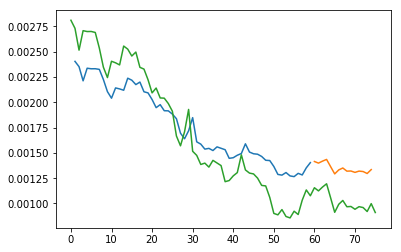

In [5]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

trainPredictPlot = np.empty_like(ds)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(ds)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+1:len(ds)-1, :] = testPredict

plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.plot(scaler.inverse_transform(ds))
plt.show()

In [13]:
list(testPredict.flatten())

[0.0014147296,
 0.0013987547,
 0.0014183754,
 0.0014351076,
 0.0013633746,
 0.0012923701,
 0.0013316454,
 0.0013505074,
 0.0013194561,
 0.0013207634,
 0.0013071117,
 0.0013197941,
 0.0013155148,
 0.0012961731,
 0.0013347017]

In [51]:
def create_dataset(self, dataset, lookback=1):
    dataX, dataY = [], []
    for i in range(0, len(dataset) - lookback):
        dataY.append(dataset[i + lookback, 0])
        dataX.append(dataset[i])
    return np.array(dataX), np.array(dataY)

def train_test_split(self, data, test_size=0.2):
    train_set_size = int(len(data) * (1 - test_size))
    train_set = data[:train_set_size]
    test_set = data[-(len(data) - train_set_size):]
    return train_set, test_set

def predict(self, ds):

    ds = ds['close'].dropna(how='all')
    ds = ds.values.reshape(len(ds), 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    ds = scaler.fit_transform(ds)

    train, test = self.train_test_split(ds)

    look_back = 1
    X_train, y_train = self.create_dataset(train, look_back)
    X_test, y_test = self.create_dataset(test, look_back)

    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    model = Sequential()
    model.add(LSTM(8, input_shape=(1, look_back), dropout=0.2))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=23, batch_size=1, verbose=2)

    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([y_train])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([y_test])

    return trainPredict, testPredict